# Customer Churn

Example from *Fundamentals of Machine Learning for Predictive Data Analytics*, Chapter 12

In [1]:
# %load nbheader.py
%reload_ext autoreload
%autoreload 2
from typing import List, Tuple, Dict, Any, Union
import sys
import os
import re
import json
import datetime
import numpy as np
import pandas as pd
settings = {
    'max_columns': 50,
    'max_colwidth': 100,
    # 'min_rows':40,
    'max_rows': 200,
    # 'precision': 3,
    'float_format': lambda x: f'{x:,.3f}',
    }
for option, value in settings.items():
    pd.set_option("display.{}".format(option), value)
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree
# import pydot_ng as pdot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import itertools


In [2]:
from helper import *

In [3]:
DATA_TABLE = '/data/IFI8410/FMLPDAInChapterDatasets/Chapter9/ACMETelephoneABT.csv'

In [53]:
! cat /data/IFI8410/FMLPDAInChapterDatasets/Chapter9/ACMETelephoneABT.csv

1099988,34, , suburban, yes, false,6,1,773, true,0, A, false, true,0,0,0,0,0,0,0,0,0,0,1.19760479,13.68428845,0,25,0,0,0,0, true.33,0,0,0, true407414,7.67,33,1,0,0,0, trueuerue truetrue0, trueeuetrueOverBundleMins,avgRoamCalls,callMinutesChangePct,billAmountChangePct,avgReceivedMins,avgOutCalls,avgInCalls,peakOffPeakRatio,peakOffPeakRatioChangePct,avgDroppedCalls,lifeTime,lastMonthCustomerCareCalls,numRetentionCalls,numRetentionOffersAccepted,newFrequentNumbers,churnlse1.26,13,4.33,3.50788002,-10.55029566,9.67,26,0.67,0,0,2, true30, professional, , no, false,3,1,345, true,0, C, false, true,67.41,446.75,43.7,56.5,0.9,-0.375,-0.001,53.87,13.67,0,1.512884615,-9.458369057,9.67,12,0,0,0,0, true

In [ ]:
def convert_to_num(x):
    try:
        return float(x)
    except:
        return np.NaN
    
df['some_num_str'].map(convert_to_num)

In [4]:
raw_df = pd.read_csv(DATA_TABLE)
# Some of the column names have leading spaces. Remove!
raw_df.rename(lambda c: c.strip(), axis=1, inplace=True)
print_shape(raw_df)

Number of rows: 10,000
Number of cols: 33


In [5]:
dtypes_table = raw_df.dtypes.reset_index()
dtypes_table.columns = ['field', 'dtype']
for col in dtypes_table[dtypes_table['dtype'] == 'object']['field']:
    print(col)
    raw_df[col] = raw_df[col].map(lambda s: s.strip() if isinstance(s, str) else s)
    

occupation
regionType
marriageStatus
children
smartPhone
creditRating
homeOwner
creditCard
churn


In [6]:
raw_df.head(3).T

,0,1,2
customer,1000004,1000012,1000034
age,26,36,74
occupation,crafts,,professional
regionType,town,,town
marriageStatus,yes,yes,yes
children,true,true,false
income,6,9,7
numHandsets,1,4,2
handsetAge,1812,544,138
smartPhone,false,true,true


In [48]:
raw_df.columns

Index(['customer', 'age', 'occupation', 'regionType', 'marriageStatus',
       'children', 'income', 'numHandsets', 'handsetAge', 'smartPhone',
       'currentHandsetPrice', 'creditRating', 'homeOwner', 'creditCard',
       'avgBill', 'avgMins', 'avgrecurringCharge', 'avgOverBundleMins',
       'avgRoamCalls', 'callMinutesChangePct', 'billAmountChangePct',
       'avgReceivedMins', 'avgOutCalls', 'avgInCalls', 'peakOffPeakRatio',
       'peakOffPeakRatioChangePct', 'avgDroppedCalls', 'lifeTime',
       'lastMonthCustomerCareCalls', 'numRetentionCalls',
       'numRetentionOffersAccepted', 'newFrequentNumbers', 'churn'],
      dtype='object')

In [49]:
describe_numeric = raw_df.describe()
numeric_cols = list(describe_numeric.columns)
other_cols = list(set(raw_df.columns) - set(numeric_cols))
other_cols
describe_other = raw_df[other_cols].describe()

In [50]:
describe_numeric.T

,count,mean,std,min,25%,50%,75%,max
customer,"10,000.000","1,049,973.765","28,798.411","1,000,001.000","1,025,200.500","1,049,833.000","1,074,990.250","1,099,988.000"
age,"10,000.000",30.318,22.159,0.000,0.000,34.000,48.000,98.000
income,"10,000.000",4.294,3.140,0.000,0.000,5.000,7.000,9.000
numHandsets,"10,000.000",1.804,1.345,1.000,1.000,1.000,2.000,21.000
handsetAge,"10,000.000",390.172,257.077,-5.000,210.000,339.000,525.000,"1,812.000"
currentHandsetPrice,"10,000.000",35.731,57.073,0.000,0.000,0.000,59.990,499.990
avgBill,"10,000.000",58.928,43.890,0.000,33.328,49.205,71.763,584.230
avgMins,"10,000.000",521.171,540.435,0.000,150.627,359.625,709.188,"6,336.250"
avgrecurringCharge,"10,000.000",46.237,23.965,0.000,30.000,44.990,59.990,337.980
avgOverBundleMins,"10,000.000",42.393,106.374,0.000,0.000,3.000,43.750,"4,320.750"


In [51]:
describe_other.T

,count,unique,top,freq
creditCard,10000,6,true,6537
marriageStatus,10000,3,unknown,3920
regionType,10000,8,,4776
children,10000,2,false,7559
occupation,10000,8,,7400
smartPhone,10000,2,true,9015
homeOwner,10000,2,false,6577
creditRating,10000,7,B,3785
churn,10000,2,false,5000


In [12]:
d_other = describe_other.T.reset_index()
bool_cols = d_other[(d_other['unique']==2)&(d_other['index']!='churn')]['index'].to_list()
cat_cols = d_other[d_other['unique']>2]['index'].to_list()
bool_cols, cat_cols

(['children', 'smartPhone', 'homeOwner'],
 ['creditCard', 'marriageStatus', 'regionType', 'occupation', 'creditRating'])

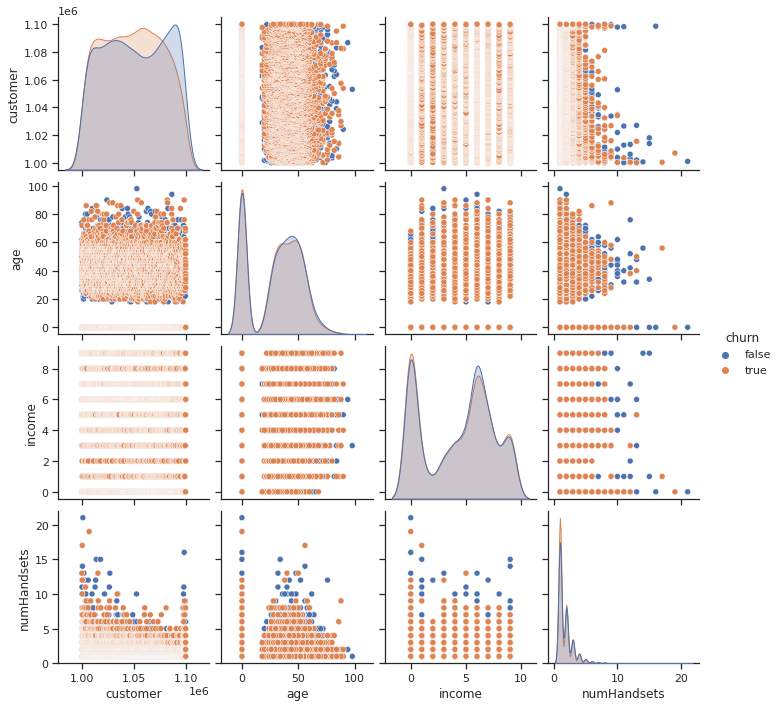

In [13]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(raw_df[numeric_cols[:4]+['churn']], hue="churn")

## Convert Categorical Features
Level to index

In [14]:
def levels2index(levels):
    dct = {}
    for i in range(len(levels)):
        dct[levels[i]] = i
    return dct

df_num = raw_df.copy()

for c in cat_cols:
    level_substitution = levels2index(raw_df[c].unique())
    df_num[c].replace(level_substitution, inplace=True)

In [52]:
raw_df['occupation'].unique()

array(['crafts', '', 'professional', 'homemaker', 'clerical',
       'self-employed', 'retired', 'student'], dtype=object)

In [15]:
df_num[cat_cols].head()

,creditCard,marriageStatus,regionType,occupation,creditRating
0,0,0,0,0,0
1,0,0,1,1,1
2,0,0,0,2,1
3,0,1,2,1,0
4,0,0,0,1,1


In [16]:
for c in bool_cols: 
    df_num[c].replace({'false':0, 'true':1}, inplace=True)
    
display(df_num[bool_cols].head())

,children,smartPhone,homeOwner
0,1,0,1
1,1,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [17]:
df_num['churn'].replace({'false':0, 'true':1}, inplace=True)

In [18]:
df_num.churn.values

array([0, 0, 0, ..., 1, 1, 1])

## Create X and y

In [19]:
X = df_num[numeric_cols + cat_cols + bool_cols].values
display(X)

array([[1.000004e+06, 2.600000e+01, 6.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [1.000012e+06, 3.600000e+01, 9.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 0.000000e+00],
       [1.000034e+06, 7.400000e+01, 7.000000e+00, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [1.099939e+06, 2.800000e+01, 2.000000e+00, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [1.099965e+06, 0.000000e+00, 7.000000e+00, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [1.099988e+06, 3.400000e+01, 6.000000e+00, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00]])

In [20]:
df_num.shape, X.shape

((10000, 33), (10000, 32))

In [21]:
y = df_num.churn
display(y)

0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: churn, Length: 10000, dtype: int64

In [22]:
# for d in [3, 5, 7, 11, 13]:
d = 99
for j in range(10):
    print(f"Iteration {j+1}")
    clf = DecisionTreeClassifier(max_depth=d)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4) ## , random_state=42)
    clf.fit(X_train, y_train)
    ŷ = clf.predict(X_test)
    print('Depth %d' % d)
    print(classification_report(y_test, ŷ))

Iteration 1
Depth 99
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      1992
           1       0.55      0.54      0.55      2008

    accuracy                           0.55      4000
   macro avg       0.55      0.55      0.55      4000
weighted avg       0.55      0.55      0.55      4000

Iteration 2
Depth 99
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      1998
           1       0.54      0.55      0.54      2002

    accuracy                           0.54      4000
   macro avg       0.54      0.54      0.54      4000
weighted avg       0.54      0.54      0.54      4000

Iteration 3
Depth 99
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      1978
           1       0.54      0.51      0.52      2022

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.53      4000
weighted av

In [26]:
df_num.columns

Index(['customer', 'age', 'occupation', 'regionType', 'marriageStatus',
       'children', 'income', 'numHandsets', 'handsetAge', 'smartPhone',
       'currentHandsetPrice', 'creditRating', 'homeOwner', 'creditCard',
       'avgBill', 'avgMins', 'avgrecurringCharge', 'avgOverBundleMins',
       'avgRoamCalls', 'callMinutesChangePct', 'billAmountChangePct',
       'avgReceivedMins', 'avgOutCalls', 'avgInCalls', 'peakOffPeakRatio',
       'peakOffPeakRatioChangePct', 'avgDroppedCalls', 'lifeTime',
       'lastMonthCustomerCareCalls', 'numRetentionCalls',
       'numRetentionOffersAccepted', 'newFrequentNumbers', 'churn'],
      dtype='object')

In [23]:
import shap

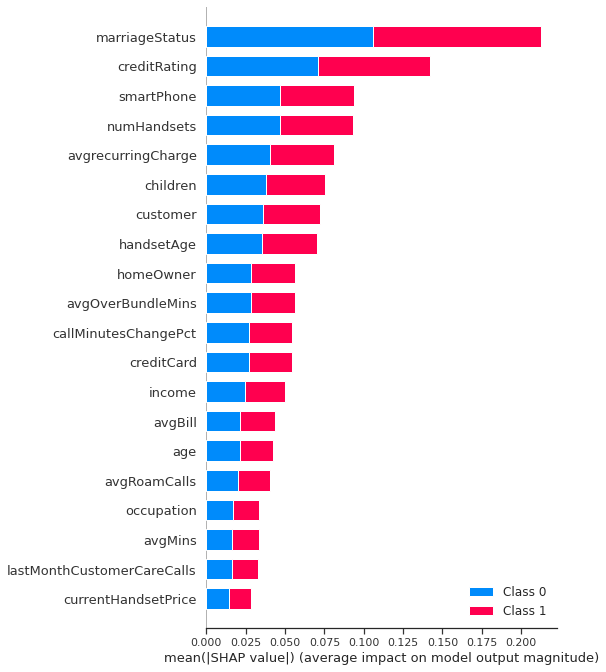

In [30]:
fig = plt.figure(figsize=(15,8))
# shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap_values = shap.TreeExplainer(clf).shap_values(X_test, )
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names = ['customer', 'age', 'occupation', 'regionType', 'marriageStatus',
       'children', 'income', 'numHandsets', 'handsetAge', 'smartPhone',
       'currentHandsetPrice', 'creditRating', 'homeOwner', 'creditCard',
       'avgBill', 'avgMins', 'avgrecurringCharge', 'avgOverBundleMins',
       'avgRoamCalls', 'callMinutesChangePct', 'billAmountChangePct',
       'avgReceivedMins', 'avgOutCalls', 'avgInCalls', 'peakOffPeakRatio',
       'peakOffPeakRatioChangePct', 'avgDroppedCalls', 'lifeTime',
       'lastMonthCustomerCareCalls', 'numRetentionCalls',
       'numRetentionOffersAccepted', 'newFrequentNumbers'])


In [31]:
X2 = df_num[['marriageStatus', 'creditRating', 'smartPhone', 'numHandsets',]].values
display(X2)

array([[0, 0, 0, 1],
       [0, 1, 1, 4],
       [0, 1, 1, 2],
       ...,
       [1, 5, 1, 4],
       [2, 3, 1, 5],
       [0, 1, 1, 1]])

In [32]:
for d in [3, 5, 7, 11, 13]:
    print(f"Iteration {j+1}")
    clf = DecisionTreeClassifier(max_depth=d)
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=.4) ## , random_state=42)
    clf.fit(X_train, y_train)
    ŷ = clf.predict(X_test)
    print('Depth %d' % d)
    print(classification_report(y_test, ŷ))

Iteration 10
Depth 3
              precision    recall  f1-score   support

           0       0.53      0.80      0.64      2029
           1       0.57      0.27      0.36      1971

    accuracy                           0.54      4000
   macro avg       0.55      0.53      0.50      4000
weighted avg       0.55      0.54      0.50      4000

Iteration 10
Depth 5
              precision    recall  f1-score   support

           0       0.54      0.66      0.59      2003
           1       0.56      0.44      0.49      1997

    accuracy                           0.55      4000
   macro avg       0.55      0.55      0.54      4000
weighted avg       0.55      0.55      0.54      4000

Iteration 10
Depth 7
              precision    recall  f1-score   support

           0       0.52      0.72      0.60      1974
           1       0.56      0.35      0.43      2026

    accuracy                           0.53      4000
   macro avg       0.54      0.53      0.51      4000
weighted av

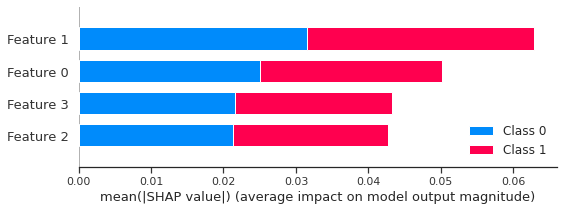

In [33]:
fig = plt.figure(figsize=(15,8))
# shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap_values = shap.TreeExplainer(clf).shap_values(X_test, )
shap.summary_plot(shap_values, X_train, plot_type="bar",)

In [34]:
from sklearn import tree

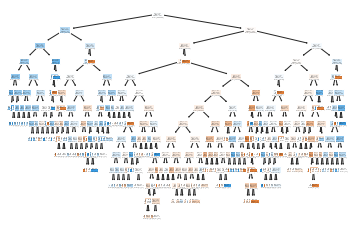

In [36]:
tree.plot_tree(clf, filled=True)
plt.show()

In [39]:
text_representation = tree.export_text(clf,
                                       feature_names=['marriageStatus', 'creditRating', 'smartPhone', 'numHandsets',])
print(text_representation)

|--- smartPhone <= 0.50
|   |--- creditRating <= 1.50
|   |   |--- numHandsets <= 3.50
|   |   |   |--- marriageStatus <= 0.50
|   |   |   |   |--- creditRating <= 0.50
|   |   |   |   |   |--- numHandsets <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- numHandsets >  1.50
|   |   |   |   |   |   |--- numHandsets <= 2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- numHandsets >  2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- creditRating >  0.50
|   |   |   |   |   |--- numHandsets <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- numHandsets >  1.50
|   |   |   |   |   |   |--- numHandsets <= 2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- numHandsets >  2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- marriageStatus >  0.50
|   |   |   |   |--- numHandsets <= 1.50
|   |   |   |   |   |--- marriageStatus <= 1.50
|   |   |   |   |   |   |--- creditRatin

## Textbook

In [45]:
X3 = df_num[['avgOverBundleMins', 'billAmountChangePct', 'handsetAge', 'billAmountChangePct']]
X3.shape

(10000, 4)

In [47]:
for d in [3, 5, 7, 11, 13, 99]:
    print(f"Iteration {j+1}")
    clf = DecisionTreeClassifier(max_depth=d)
    X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=.4) ## , random_state=42)
    clf.fit(X_train, y_train)
    ŷ = clf.predict(X_test)
    print('Depth %d' % d)
    print(classification_report(y_test, ŷ))

Iteration 10
Depth 3
              precision    recall  f1-score   support

           0       0.61      0.49      0.54      1988
           1       0.58      0.69      0.63      2012

    accuracy                           0.59      4000
   macro avg       0.59      0.59      0.58      4000
weighted avg       0.59      0.59      0.58      4000

Iteration 10
Depth 5
              precision    recall  f1-score   support

           0       0.59      0.45      0.51      1958
           1       0.57      0.70      0.63      2042

    accuracy                           0.58      4000
   macro avg       0.58      0.58      0.57      4000
weighted avg       0.58      0.58      0.57      4000

Iteration 10
Depth 7
              precision    recall  f1-score   support

           0       0.59      0.50      0.54      2013
           1       0.56      0.64      0.60      1987

    accuracy                           0.57      4000
   macro avg       0.57      0.57      0.57      4000
weighted av